## Postmodeling Analysis Report for ACLU Bill Passage

This is following the same template as given in the CSF repo: https://github.com/dssg/CSF-vaccination/blob/master/notebooks/postmodeling_csf.ipynb

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from triage.component.postmodeling.contrast.utils.aux_funcs import get_models_ids

from src.utils.general import get_db_conn
from src.utils import project_constants as constants
from src.bill_passage.postmodeling.model_evaluator import ModelEvaluatorACLU
from sklearn import metrics

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/home/kasun/.pyenv/versions/aclu/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


#### Connections

In [4]:
cred_file = '../conf/local/credentials.yaml'
db_conn=get_db_conn(cred_file, conn_type='sqlalchemy')

# My crosstabs code depnds on a psycopg2
# TODO -- FIX
db_conn_psycopg2 = get_db_conn(cred_file)

project_path = 's3://aclu-leg-tracker/experiment_data/bill_passage/triage/national_lt'

# experiment_hash = '170870efbfa049eff695a0423dfe5ea8'

experiment_hash = '5bf28511f823b995bb5f843574ba2282' # Fixing the bill age

#### Model Groups

_We can select model collections (that span across different model groups) based on rules as well. Starting with the assumption that all the model_ids we are inspecting are of the same model group._

**NOTE** -- The predictions need to be saved for the models we are interested in

- small RF: 
    - {'model_group_id': 654, 'hyperparameters': "{'criterion': 'gini', 'max_depth': 15, 'class_weight': None, 'max_features': 'sqrt', 'n_estimators': 10, 'min_samples_split': 10}"}
- medium RF
    - {'model_group_id': 687, 'hyperparameters': "{'criterion': 'gini', 'max_depth': 25, 'class_weight': None, 'max_features': 'sqrt', 'n_estimators': 100, 'min_samples_split': 100}"}
- large RF
   - {'model_group_id': 716, 'hyperparameters': "{'criterion': 'gini', 'max_depth': 100, 'class_weight': None, 'max_features': 'sqrt', 'n_estimators': 2000, 'min_samples_split': 10}"}

In [5]:
# model_group_ids = [
#     654, 
# #     687, 
#     716]

model_group_ids = [751, 731]
baselines = [733]

#### 1. Score distributions

We will plot score distribution for each model id (within each model group) and train_end_time here

In [6]:
# fetching the model ids for the model groups
q = """
    select 
        model_id, to_char(train_end_time, 'YYYY-MM-DD') as train_end_time, model_group_id
    from triage_metadata.models where model_group_id in ({})
    and train_end_time >='2018-01-01'
""".format(','.join([str(x) for x in model_group_ids]))

models = pd.read_sql(q, db_conn)

In [7]:
# models

In [8]:
train_end_times = list(models['train_end_time'].unique())

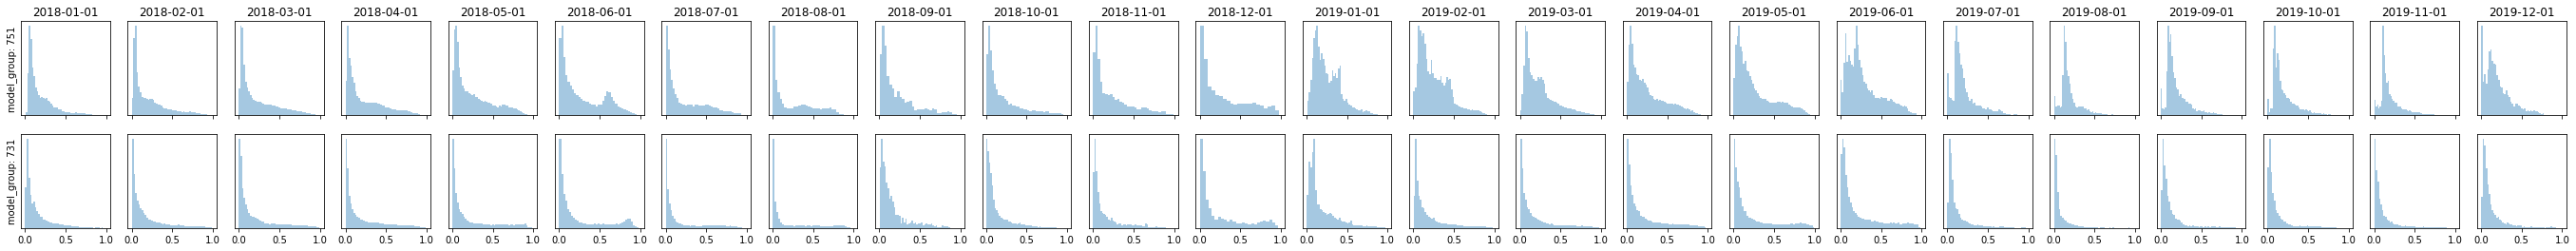

In [15]:
# %%capture
fig, axes = plt.subplots( 
    len(model_group_ids), 
    len(train_end_times),
    figsize=(len(train_end_times)*2, len(model_group_ids)*2),
    sharex=True
)

# fig.suptitle('Comparing score distributions across time for the model groups')
for j, end_time in enumerate(train_end_times):
    for i, model_group in enumerate(model_group_ids):
        msk = (models['model_group_id'] == model_group) & (models['train_end_time'] == end_time)
        model_id = models[msk]['model_id'].iloc[0]
        
        q = """
            select 
                score
            from test_results.predictions 
            where model_id={}
        """.format(model_id)
        
        scores = pd.read_sql(q, db_conn)
        sns.distplot(scores['score'], kde=False, ax=axes[i, j])   
        axes[i, j].set_yticks([])
        axes[i, j].set_xlabel('')
        if i==0:
            axes[i, j].set_title(end_time)
        if j==0:
            axes[i,j].set_ylabel('model_group: {}'.format(model_group))

#### 2. Performance

We will look at the performance of each model group at each train_end_time. The performance metric is defined earlier and we cn also specify baselines in the baseline query

In [9]:
metric = 'precision@'
parameter = '20_pct'

In [10]:
# baselines = [591, 593]
# baselines = 

#### 2A. Performance over time

We will look at the performance of each model group at each train_end_time. The performance metric is defined earlier and we cn also specify baselines in the baseline query

In [11]:
q = """
        select 
            model_group_id,
            model_id,
            train_end_time,
            metric,
            parameter,
            model_type,
            hyperparameters,
            hyperparameters::TEXT as hyperparameter_str,
            stochastic_value as metric_value
        from triage_metadata.models join test_results.evaluations e using(model_id)
        where metric='{}'
        and parameter='{}'
        and subset_hash=''
        and model_group_id in ({})
""".format(
    metric, parameter, ','.join([str(x) for x in model_group_ids + baselines])
)

evaluations = pd.read_sql(q, db_conn)

Text(0.5, 1.0, 'precision@20_pct over time')

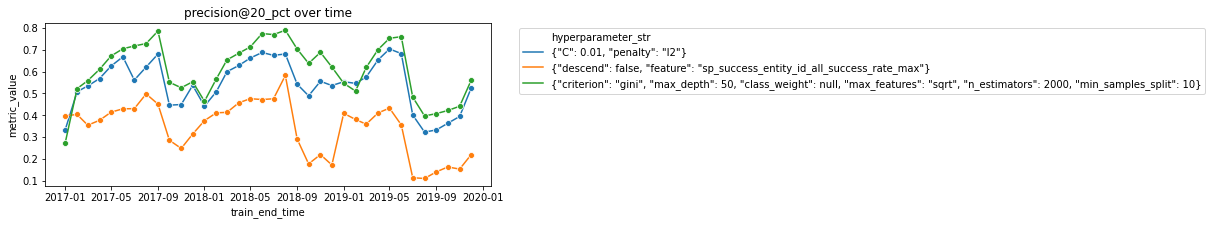

In [12]:
fig, ax = plt.subplots(figsize=(8, 3))
sns.lineplot(
    data=evaluations, 
    x='train_end_time', 
    y='metric_value', 
    hue='hyperparameter_str', 
    marker='o', 
#     style='parameter', 
    estimator='mean', ci='sd')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.set_title('{}{} over time'.format(metric, parameter))

#### 2B. Precision Recall Curves

for each model id (within each model group) and train_end_time here

This cell below (probably hidden) uses the predictions of the model to generate the precision-recall curve. It is really SLOW, when we try to plot a bunch of model_ids belonging to several model groups. For now, going to use the evaluations table to plot the PR curve (assuming that the config file calculated evaluations at sufficiently granular intervals) 

In [57]:
# fig, axes = plt.subplots(
#     len(train_end_times), 
#     len(model_group_ids), 
#     figsize=(len(model_group_ids)*2, len(train_end_times)*2),
#     sharex=True
# )

# # fig.suptitle('Comparing score distributions across time for the model groups')
# for i, end_time in enumerate(train_end_times):
#     for j, model_group in enumerate(model_group_ids):
#         msk = (models['model_group_id'] == model_group) & (models['train_end_time'] == end_time)
#         model_id = models[msk]['model_id'].iloc[0]
#         model_eval = ModelEvaluatorACLU(engine=db_conn, model_group_id=model_group, model_id=model_id)
        
#         _labels = model_eval.predictions[['label_value', 'score']]
#         y_score = _labels.score
#         precision_curve, recall_curve, pr_thresholds = metrics.precision_recall_curve(
#             _labels.label_value, 
#             y_score
#         )
        
#         precision_curve = precision_curve[:-1]
#         recall_curve = recall_curve[:-1]
        
#         pr_thresholds = np.insert(pr_thresholds, 0, 0)
#         precision_curve = np.insert(precision_curve, 0, precision_curve[0])
#         recall_curve = np.insert(recall_curve, 0, recall_curve[0])
        
#         pct_above_per_thresh = []
#         for value in pr_thresholds:
#             num_above_thresh = len(y_score[y_score >= value])
#             pct_above_thresh = num_above_thresh / float(len(y_score))
#             pct_above_per_thresh.append(pct_above_thresh)
#         pct_above_per_thresh = np.array(pct_above_per_thresh)
        
#         ax = axes[i, j]
#         ax.plot(pct_above_per_thresh, precision_curve, "#000099")
#         ax.set_xlabel('Proportion of population', fontsize=10)
#         ax.set_ylabel('Precision', color="#000099", fontsize=10)
#         plt.ylim([0.0, 1.05])
#         ax2 = ax.twinx()
#         ax2.plot(pct_above_per_thresh, recall_curve, "#CC0000")
#         ax2.set_ylabel('Recall', color="#CC0000", fontsize=10)
#         plt.xlim([0.0, 1.0])
#         plt.ylim([0.0, 1.05])
#         axes[i, j].set_yticks([])
#         axes[i, j].set_xlabel('')
        
#         if j==0:
#             axes[i, j].set_ylabel(end_time)
#         if i==0:
#             axes[i,j].set_title('model_group: {}'.format(model_group))
        
        

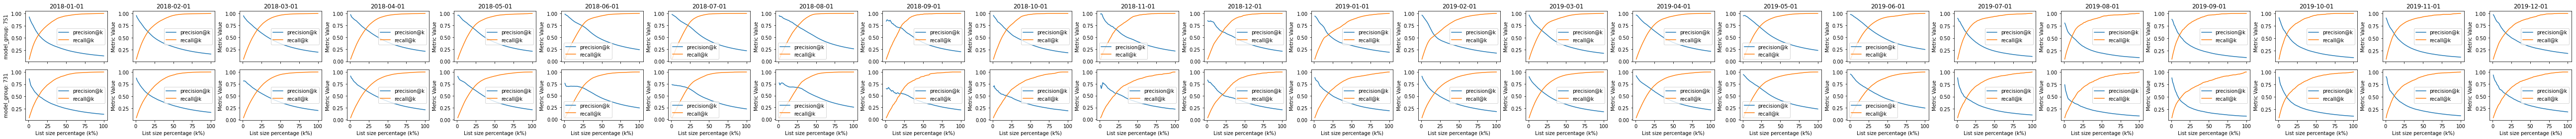

In [17]:
fig, axes = plt.subplots(
    len(model_group_ids), 
    len(train_end_times), 
    figsize=(len(train_end_times)*3, len(model_group_ids)*2),
    sharex=True
)


for j, end_time in enumerate(train_end_times):
    for i, model_group in enumerate(model_group_ids):
        msk = (models['model_group_id'] == model_group) & (models['train_end_time'] == end_time)
        model_id = models[msk]['model_id'].iloc[0]
        q = """
            select 
                model_id,
                parameter,
                metric,
                stochastic_value
            from test_results.evaluations
            where model_id={} and subset_hash='' 
        """.format(model_id)
        
        eval_model = pd.read_sql(q, db_conn)
        
        eval_model['perc_points'] = [x.split('_')[0] for x in eval_model['parameter'].tolist()]
        eval_model['perc_points'] = pd.to_numeric(eval_model['perc_points'])
        
        msk_prec = eval_model['metric']=='precision@'
        msk_recall = eval_model['metric']=='recall@'
        msk_pct = eval_model['parameter'].str.contains('pct')

        sns.lineplot(
            x='perc_points',
            y='stochastic_value', 
            data=eval_model[msk_pct & msk_prec], 
            label='precision@k',
#             marker='o', 
            ax=axes[i, j], 
            estimator='mean', ci='sd'
        )
        sns.lineplot(
            x='perc_points', 
            y='stochastic_value', 
            data=eval_model[msk_pct & msk_recall], 
            label='recall@k', 
#             marker='o', 
            ax=axes[i,j], 
            estimator='mean', 
            ci='sd'
        )
        axes[i, j].set_xlabel('List size percentage (k%)')
        axes[i,j].set_ylabel('Metric Value')
        
        if i==0:
            axes[i, j].set_title(end_time)
        if j==0:
            axes[i,j].set_ylabel('model_group: {}'.format(model_group))
            
fig.tight_layout()

#### 3. Features

#### 3A. Feature Importances

In [19]:
n_top_features = 20

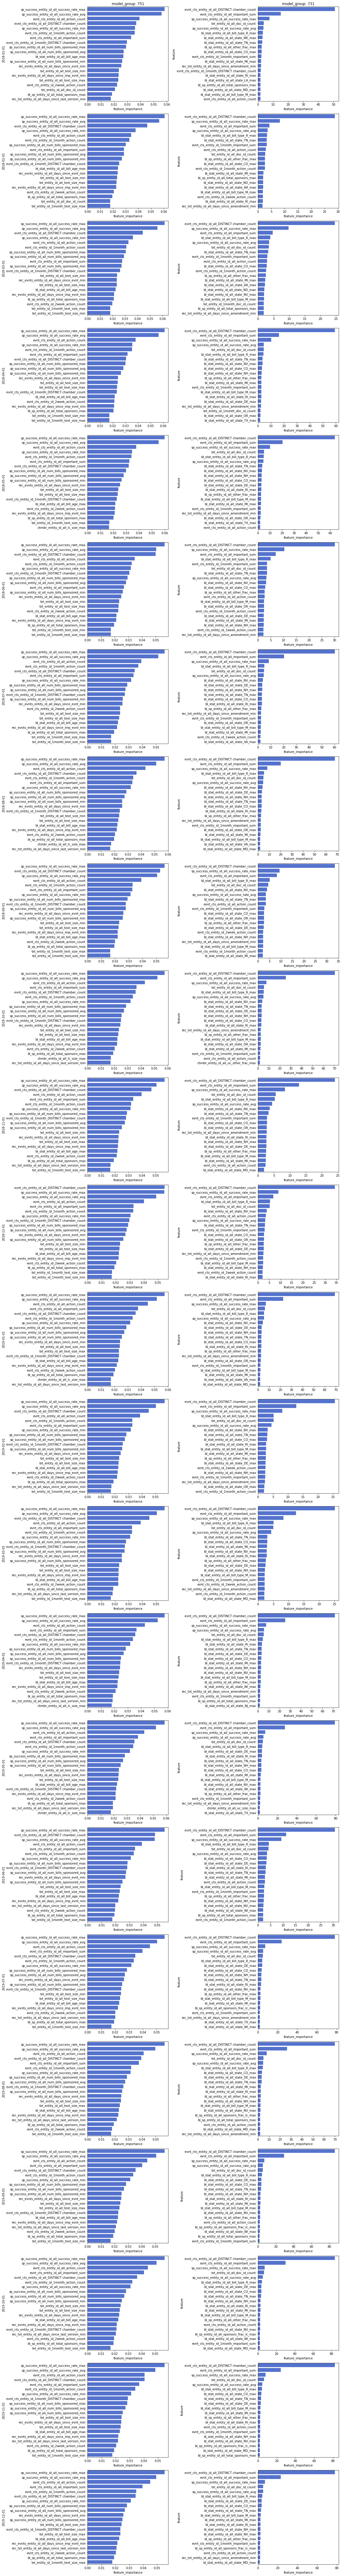

In [20]:
q = """
    select
        feature,
        feature_importance, 
        rank_abs, 
        rank_pct
    from train_results.feature_importances
    where model_id={model_id}
    and rank_abs <= {n_top_features}
    order by feature_importance desc;
"""

fig, axes = plt.subplots(
    len(train_end_times), 
    len(model_group_ids), 
    figsize=(len(model_group_ids)*8, len(train_end_times)*5),
#     sharex=True
)

# fig.suptitle('Comparing score distributions across time for the model groups')
for i, end_time in enumerate(train_end_times):
    for j, model_group in enumerate(model_group_ids):
        msk = (models['model_group_id'] == model_group) & (models['train_end_time'] == end_time)
        model_id = models[msk]['model_id'].iloc[0]
        feature_importance_scores = pd.read_sql(q.format(model_id=model_id, n_top_features=n_top_features), db_conn)
        
#         feature_importance_scores['feature_importance'].plot(kind='barh', ax=axes[i, j])
        
        sns.barplot(
            data=feature_importance_scores,
            x='feature_importance',
            y='feature',
            color='royalblue',
            ax=axes[i,j]
        )
        
        if j==0:
            axes[i, j].set_ylabel(end_time)
        if i==0:
            axes[i,j].set_title('model_group: {}'.format(model_group))
#         sns.despine()
fig.tight_layout()

#### 3B. We can also look at the feature space to see which features are correlated and which features are mostly missing

#### 3C Feature Group Importances

We can see which feature groups are more important in a few different ways:
1. max feature importance over each feature group
2. LOO and LOI performance

In [62]:
q = """
    select 
        config->'feature_group_definition'->'prefix' as feature_groups
    from triage_metadata.experiments where experiment_hash = '{}'
""".format(experiment_hash)

feature_groups = pd.read_sql(q, db_conn)['feature_groups'].iloc[0]

In [72]:
case_part = ''
for fg in feature_groups:
    case_part = case_part + "\nWHEN feature like '{fg}%%' THEN '{fg}'".format(fg=fg)

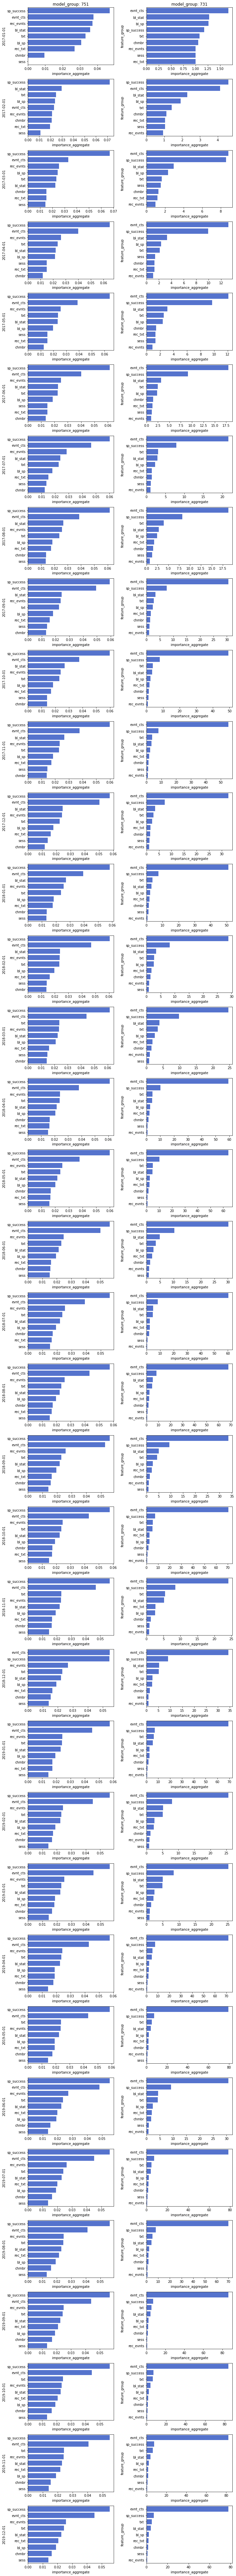

In [78]:
fig, axes = plt.subplots(
    len(train_end_times), 
    len(model_group_ids), 
    figsize=(len(model_group_ids)*5, len(train_end_times)*3),
)

q = """
    with raw_importances as (
        select 
            model_id,
            feature,
            feature_importance,
            CASE {case_part}
            ELSE 'No feature group'
            END as feature_group
        FROM train_results.feature_importances
        WHERE model_id = {model_id}
    )
    SELECT
    model_id,
    feature_group,
        max(feature_importance) as importance_aggregate
    FROM raw_importances
    GROUP BY feature_group, model_id
    ORDER BY importance_aggregate desc;
"""

for i, end_time in enumerate(train_end_times):
    for j, model_group in enumerate(model_group_ids):
        msk = (models['model_group_id'] == model_group) & (models['train_end_time'] == end_time)
        model_id = models[msk]['model_id'].iloc[0]
        
        feature_group_importance = pd.read_sql(q.format(case_part=case_part, model_id=model_id), db_conn)
        
        sns.barplot(
            data=feature_group_importance,
            x='importance_aggregate',
            y='feature_group',
            color='royalblue',
            ax=axes[i,j]
        )
        
        if j==0:
            axes[i, j].set_ylabel(end_time)
        if i==0:
            axes[i,j].set_title('model_group: {}'.format(model_group))
#         sns.despine()
fig.tight_layout()

#### 4. Cross-tabs

Cross-tabs for each model id (within each model group) and train_end_time here. With crosstabs, we observe the differences in feature distribution across the different passage likelihood categories. 

In [25]:
from triage.component.postmodeling.crosstabs import CrosstabsConfigLoader
from src.bill_passage.postmodeling.crosstabs import run_crosstabs, bin_mean, bin_n, bin_std, ratio_bins, bins_ttest

In [29]:
config = {
    'model_ids': models['model_id'].tolist(),
    'output': {
        'schema': 'test_results',
        'table': 'crosstabs'
    },
    'thresholds': {
        'score_bins': {
            'will_not_pass': [0, 0.10],
            'unlikely': [0.10, 0.35],
            'coin-toss': [0.35, 0.55],
            'likely': [0.55, 0.70],
            'very_likely': [0.70, 0.90],
            'will_pass': [0.90, 1.0],
        }
    },
    'project_path': project_path
}
config = CrosstabsConfigLoader(config=config)
single_bin_metrics = {
    "count": bin_n,
    "mean": bin_mean,
    "std": bin_std
}

multi_bin_metrics = {
    "mean_ratio": ratio_bins,
    'ttest':  bins_ttest
}


In [ ]:
run_crosstabs(
    db_conn_psycopg2,
    config,
    single_bin_metrics,
    multi_bin_metrics
)

2021-10-08 17:30:50 -    INFO Checking whether the crosstabs table test_results.crosstabs exist in DB. If not, creating
2021-10-08 17:30:50 -    INFO Found credentials in shared credentials file: ~/.aws/credentials
2021-10-08 17:30:52 -    INFO Calculating count for likelihood bin -- will_not_pass
2021-10-08 17:30:52 -    INFO Calculating mean for likelihood bin -- will_not_pass
2021-10-08 17:30:52 -    INFO Calculating std for likelihood bin -- will_not_pass
2021-10-08 17:30:52 -    INFO Calculating count for likelihood bin -- unlikely
2021-10-08 17:30:52 -    INFO Calculating mean for likelihood bin -- unlikely
2021-10-08 17:30:52 -    INFO Calculating std for likelihood bin -- unlikely
2021-10-08 17:30:52 -    INFO Calculating count for likelihood bin -- coin-toss
2021-10-08 17:30:52 -    INFO Calculating mean for likelihood bin -- coin-toss
2021-10-08 17:30:52 -    INFO Calculating std for likelihood bin -- coin-toss
2021-10-08 17:30:52 -    INFO Calculating count for likelihood bi

In [52]:
# taking the cross tabs for the random forest ones
model_ids = models[models['model_group_id']==751]['model_id'].astype(str).tolist()
q = """select * from test_results.crosstabs where model_id in ({}) and value < 10000""".format(', '.join(model_ids))
ct = pd.read_sql(q, db_conn)

In [53]:
ct_201903 = ct[ct['train_end_time']=='2019-03-01']

In [54]:
ct_201903_pivot = ct_201903.pivot_table(index=['model_id', 'train_end_time', 'feature_name', 'related_likelihood_bins'], columns='metric', values='value')

In [56]:
ct_201903_pivot.sort_values('mean_ratio', ascending=False).head(20)

metric                                                                                       count  \
model_id train_end_time feature_name                              related_likelihood_bins            
17671    2019-03-01     txt_entity_id_1week_num_amended_texts_sum will_pass/will_not_pass   NaN      
                        bl_stat_entity_id_all_state_CO_max        will_pass/will_not_pass   NaN      
                        txt_entity_id_1week_num_amended_texts_sum very_likely/will_not_pass NaN      
                        bl_stat_entity_id_all_state_CO_max        very_likely/will_not_pass NaN      
                        txt_entity_id_1week_num_amended_texts_sum coin-toss/will_not_pass   NaN      
                                                                  likely/will_not_pass      NaN      
                        txt_entity_id_2week_num_amended_texts_sum will_pass/will_not_pass   NaN      
                        bl_stat_entity_id_all_state_MN_max        will_not_pass/very_likely NaN      
                        bl_stat_entity_id_all_state_CO_max        likely/will_not_pass      NaN      
                                                                  coin-toss/will_not_pass   NaN      
                        bl_stat_entity_id_all_state_MA_max        unlikely/likely           NaN      
                        txt_entity_id_1week_num_amended_texts_sum unlikely/will_not_pass    NaN      
                        bl_stat_entity_id_all_state_MN_max        unlikely/very_likely      NaN      
                        evnt_cts_entity_id_1week_action_count     will_pass/will_not_pass   NaN      
                        bl_stat_entity_id_all_state_ID_max        will_pass/unlikely        NaN      
                        txt_entity_id_2week_num_amended_texts_sum very_likely/will_not_pass NaN      
                        bl_stat_entity_id_all_state_RI_max        unlikely/will_not_pass    NaN      
                                                                  coin-toss/will_not_pass   NaN      
                        bl_stat_entity_id_all_state_MD_max        likely/will_not_pass      NaN      
                        evnt_cts_entity_id_1month_important_imp   will_not_pass/very_likely NaN      

metric                                                                                       mean  \
model_id train_end_time feature_name                              related_likelihood_bins           
17671    2019-03-01     txt_entity_id_1week_num_amended_texts_sum will_pass/will_not_pass   NaN     
                        bl_stat_entity_id_all_state_CO_max        will_pass/will_not_pass   NaN     
                        txt_entity_id_1week_num_amended_texts_sum very_likely/will_not_pass NaN     
                        bl_stat_entity_id_all_state_CO_max        very_likely/will_not_pass NaN     
                        txt_entity_id_1week_num_amended_texts_sum coin-toss/will_not_pass   NaN     
                                                                  likely/will_not_pass      NaN     
                        txt_entity_id_2week_num_amended_texts_sum will_pass/will_not_pass   NaN     
                        bl_stat_entity_id_all_state_MN_max        will_not_pass/very_likely NaN     
                        bl_stat_entity_id_all_state_CO_max        likely/will_not_pass      NaN     
                                                                  coin-toss/will_not_pass   NaN     
                        bl_stat_entity_id_all_state_MA_max        unlikely/likely           NaN     
                        txt_entity_id_1week_num_amended_texts_sum unlikely/will_not_pass    NaN     
                        bl_stat_entity_id_all_state_MN_max        unlikely/very_likely      NaN     
                        evnt_cts_entity_id_1week_action_count     will_pass/will_not_pass   NaN     
                        bl_stat_entity_id_all_state_ID_max        will_pass/unlikely        NaN     
                        txt_entity_id_

**NOTE** -- might make sense to append the bucket name to the metric and get rid of the related_likelihood_bins column , so we can look at each metric as a column

#### 5. Error Analysis

This function error_analysis runs a Decision Tree for each model based in one (or several) thresholds passed to the Postmodeling configuration file. The function will return the tree plot (saved as pdf under the /error_analysis).

The function will make four comparisons:

False Postives (1) vs. Rest of entities classified (0)
False Negatives (1) vs. Rest of entities classified (0)
False Positives (1) vs. True Negatives (0)
False Negatives (1) vs. True Positives (0)
This set of analysis will serve to understand why some classification errors arise, and give some hints on how our model is performing.

for each model id (within each model group) and train_end_time here

#### 6. Bias Analysis

for each model id (within each model group) and train_end_time here

### Compare Model Groups

#### 1. Compare predicted lists

We can compare model_group_ids by comparing which entities they score in the top k. We can do that by looking at overlap (Jaccard Similarity Index) or by the rankings (Rank Correlation).

#### 1A. Jaccard Similarity

show one matrix for each train_end_time

#### 1B. Rank Correlation

#### 2. Compare Feature Importances

We can compare model_group_ids by comparing which features they found as important. We can do that by looking at overlap (Jaccard Similarity Index) or by the rankings (Rank Correlation).

#### 2A. Jaccard Similarity

show one matrix for each train_end_time

#### 2B. Rank Correlation

show one matrix for each train_end_time

#### 3. Compare Cross-Tabs

We will plot score distribution for each model id (within each model group) and train_end_time here

#### Compare Bias

for each model id (within each model group) and train_end_time here